## Analysis of sample radar data

This notebook contains any of my notes and/or plots during my investigation of the sample radar data Steven gave me. I likely cleaned it up considerably, so there shouldn't be too many scatter brain code cells throughout the notebook.

In [1]:
%matplotlib inline

In [3]:
import csv
import proc_sample
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import MultipleLocator

#### Read data sample

In [87]:
filename = 'C:\Users\kirkn\Downloads\Scenario_crossing_left_to_right_50mph.csv'
radar = proc_sample.read_csv(filename, verbose=True)

Number of headers: 287
Number of radar objects: 40
Number of time steps: 2021


#### Plot reference data

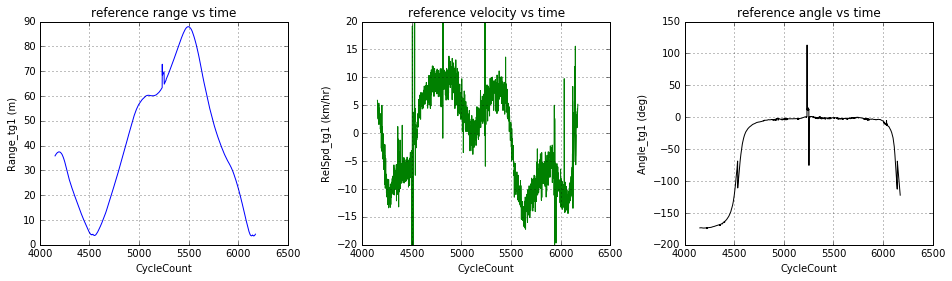

In [4]:
fig, (axa, axb, axc) = plt.subplots(nrows=1, ncols=3, sharex=True, **{'figsize': (16, 4)})
fig.subplots_adjust(wspace=0.3)
axa.plot(radar['CycleCount'], radar['CAN Global.Range_tg1'], 'b-', lw=1)
axb.plot(radar['CycleCount'], radar['CAN Global.RelSpd_tg1'], 'g-', lw=1)
axc.plot(radar['CycleCount'], radar['CAN Global.Angle_tg1'], 'k-', lw=1)
axa.set_title('reference range vs time')
axb.set_title('reference velocity vs time')
axc.set_title('reference angle vs time')
axb.set_ylim(-20, 20)
axa.set_ylabel('Range_tg1 (m)')
axb.set_ylabel('RelSpd_tg1 (km/hr)')
axc.set_ylabel('Angle_tg1 (deg)')
for ax in [axa, axb, axc]:
    ax.set_xlabel('CycleCount')
    ax.grid()
fig.savefig('reference.png', format='png', dpi=300, bbox_inches='tight')

#### Plot reference trajectory vs `aObject[32]`

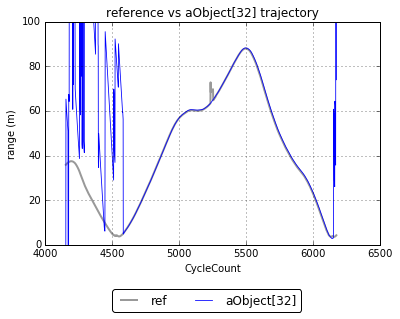

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, **{'figsize': (6, 4)})
ax.plot(radar['CycleCount'], radar['CAN Global.Range_tg1'], 'k-', lw=2, label='ref', alpha=0.4)
ax.plot(radar['CycleCount'], radar['aObject[32].Kinematic.fRange'], 'b-', lw=0.8, label='aObject[32]')
ax.set_ylim(0, 100)
ax.set_title('reference vs aObject[32] trajectory')
ax.set_xlabel('CycleCount')
ax.set_ylabel('range (m)')
ax.grid()
ax.legend(loc=(0.2, -0.3), fancybox=True, shadow=False, ncol=2)
fig.savefig('reference_object_trajectory.png', format='png', dpi=300, bbox_inches='tight')

#### Plot `aObject[32]` vs reference positional errors

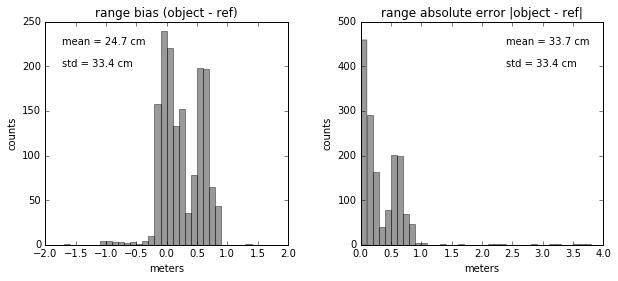

In [6]:
range_bias = radar['aObject[32].Kinematic.fRange'] - radar['CAN Global.Range_tg1']
range_abs_error = np.abs(radar['aObject[32].Kinematic.fRange'] - radar['CAN Global.Range_tg1'])
fig, (axa, axb) = plt.subplots(nrows=1, ncols=2, **{'figsize': (10, 4)})
fig.subplots_adjust(wspace=0.3)

# (a) range bias distribution
counts, edges, patches = axa.hist(range_bias, bins=200, range=(-10, 10), align='mid', normed=False,
                                lw=1, color='k', alpha=0.4)
axa.set_xlim(-2, 2)
axa.set_title('range bias (object - ref)')
axa.set_xlabel('meters')
axa.set_ylabel('counts')
axa.text(0.07, 0.9, 'mean = 24.7 cm', transform=axa.transAxes)
axa.text(0.07, 0.8, 'std = 33.4 cm', transform=axa.transAxes)

# (b) range absolute error distribution
counts, edges, patches = axb.hist(range_abs_error, bins=100, range=(0, 10), align='mid', normed=False,
                                lw=1, color='k', alpha=0.4)
axb.set_xlim(0, 4)
axb.set_title('range absolute error |object - ref|')
axb.set_xlabel('meters')
axb.set_ylabel('counts')
axb.text(0.6, 0.9, 'mean = 33.7 cm', transform=axb.transAxes)
axb.text(0.6, 0.8, 'std = 33.4 cm', transform=axb.transAxes)

fig.savefig('range_error.png', format='png', dpi=300, bbox_inches='tight')

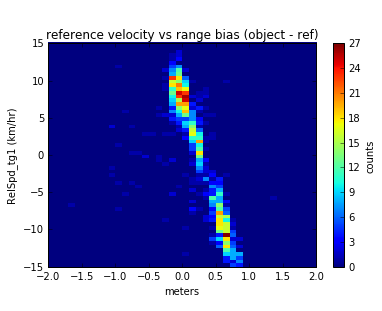

In [7]:
range_bias = np.ma.masked_outside(range_bias, -2.0, 2.0)
relspd = np.ma.masked_where(range_bias, radar['CAN Global.RelSpd_tg1'])
fig, ax = plt.subplots(nrows=1, ncols=1, **{'figsize': (6, 4)})
counts, xedges, yedges, patches = ax.hist2d(
    range_bias, relspd, bins=(40, 80), range=([-2, 2], [-20, 20]),
    cmin=None, cmax=None, cmap='jet')
ax.set_title('reference velocity vs range bias (object - ref)')
ax.set_xlim(-2, 2)
ax.set_ylim(-15, 15)
ax.set_xlabel('meters')
ax.set_ylabel('RelSpd_tg1 (km/hr)')
cb = fig.colorbar(mappable=patches, label='counts')

fig.savefig('velocity_range_bias.png', format='png', dpi=300, bbox_inches='tight')

#### Plot reference velocity vs `aObject[32]`

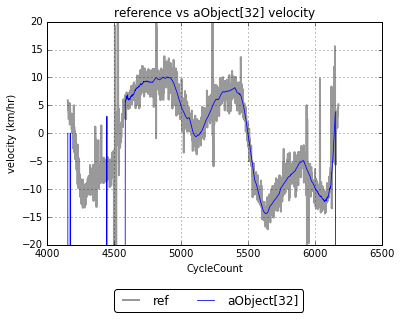

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, **{'figsize': (6, 4)})
ax.plot(radar['CycleCount'], radar['CAN Global.RelSpd_tg1'], 'k-', lw=2, label='ref', alpha=0.4)
ax.plot(radar['CycleCount'], radar['aObject[32].Kinematic.fVrel'], 'b-', lw=0.8, label='aObject[32]')
ax.set_ylim(-20, 20)
ax.set_title('reference vs aObject[32] velocity')
ax.set_xlabel('CycleCount')
ax.set_ylabel('velocity (km/hr)')
ax.grid()
ax.legend(loc=(0.2, -0.3), fancybox=True, shadow=False, ncol=2)
fig.savefig('reference_object_velocity.png', format='png', dpi=300, bbox_inches='tight')

#### Plot `aObject[32]` vs reference velocity errors

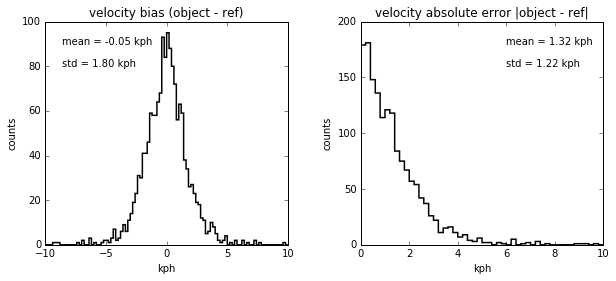

In [29]:
vel_bias = radar['aObject[32].Kinematic.fVrel'] - radar['CAN Global.RelSpd_tg1']
vel_abs_error = np.abs(radar['aObject[32].Kinematic.fVrel'] - radar['CAN Global.RelSpd_tg1'])
fig, (axa, axb) = plt.subplots(nrows=1, ncols=2, **{'figsize': (10, 4)})
fig.subplots_adjust(wspace=0.3)

# (a) velocity bias distribution
counts, edges, patches = axa.hist(
    vel_bias, bins=100, range=(-10, 10), align='mid', normed=False, lw=1.5, 
    color='k', alpha=None, histtype='step')
axa.set_xlim(-10, 10)
axa.set_title('velocity bias (object - ref)')
axa.set_xlabel('kph')
axa.set_ylabel('counts')
axa.text(0.07, 0.9, 'mean = -0.05 kph', transform=axa.transAxes)
axa.text(0.07, 0.8, 'std = 1.80 kph', transform=axa.transAxes)

# (b) range absolute error distribution
counts, edges, patches = axb.hist(
    vel_abs_error, bins=50, range=(0, 10), align='mid', normed=False, lw=1.5, 
    color='k', alpha=None, histtype='step')
axb.set_xlim(0, 10)
axb.set_title('velocity absolute error |object - ref|')
axb.set_xlabel('kph')
axb.set_ylabel('counts')
axb.text(0.6, 0.9, 'mean = 1.32 kph', transform=axb.transAxes)
axb.text(0.6, 0.8, 'std = 1.22 kph', transform=axb.transAxes)

fig.savefig('velocity_error.png', format='png', dpi=300, bbox_inches='tight')

#### Radar object data quality

The `General.uiLifeCycles` and `Attributes.eDynamicProperty` fields appear to provide a good measure of information regarding the quality of the radar object and its identification. In particular, the gradient or slope of the life cycles field should be equal to 1 as the counter increases by 1 from time step to time step. Wherever there is a jump in the slope, i.e., the counter is *restarted*, then presumably the object could not be tracked for whatever reason. 

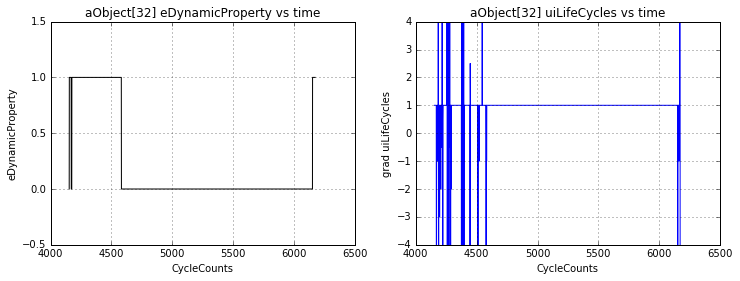

In [110]:
fig, (axa, axb) = plt.subplots(nrows=1, ncols=2, **{'figsize': (12, 4)})
fig.subplots_adjust(wspace=0.2)

# (a) dynamic property
axa.plot(radar['CycleCount'], radar['aObject[32].Attributes.eDynamicProperty'], 'k-', lw=1)
axa.set_ylim(-0.5, 1.5)
axa.set_title('aObject[32] eDynamicProperty vs time')
axa.set_xlabel('CycleCounts')
axa.set_ylabel('eDynamicProperty')
axa.grid()

# (b) gradient life cycles
axb.plot(radar['CycleCount'], np.gradient(radar['aObject[32].General.uiLifeCycles']), 'b-', lw=1)
axb.set_ylim(-4, 4)
axb.set_title('aObject[32] uiLifeCycles vs time')
axb.set_xlabel('CycleCounts')
axb.set_ylabel('grad uiLifeCycles')
axb.grid()

fig.savefig('object_quality.png', format='png', dpi=300, bbox_inches='tight')